# Similarity Explanantions (SE)

모델의 예측결과를 설명하는 가장 간단한 방법은 학습시킨 학습데이터에서 비슷한 표본을 찾아 이유를 설명하는 것이다. 즉, "$x$는 $y$이다. 왜냐하면 비슷한 $x^{\prime}$이 $y$이기 때문이다."가 SE의 핵심개념이다.

---

## Gradient Similarity (GS)

여러 가지 SE중 *Charpiat et al.(2019)* 이 제안한 gradient similarity에 대해 설명한다. 표본 $z$와 $z^{\prime}$, 학습된 모델 $f(x)$, 모델의 모수 $\boldsymbol{\theta}$, 손실함수 $L_{\theta}(z)$에 대하여 다음 과정을 통해 두 표본 간 유사성을 도출한다.

표본 $z$에 대한 손실함수에 다음과 같이 1차 테일러 전개를 적용한다. 아래의 식에서 손싱함수 값을 $\epsilon$만큼 변동시키려면 
$\delta\theta=
\epsilon\times
\frac{\nabla_\theta L_{\theta}(z)}{\|\nabla_\theta L_{\theta}(z)\|^2}$를 대입하면 된다. 즉, 손실함수값을 $\epsilon$만큼 변동시키기 위해 모델의 모수를 
$\epsilon\times
\frac{\nabla_\theta L_{\theta}(z)}{\|\nabla_\theta L_{\theta}(z)\|^2}$만큼 변화시켜야 한다는 의미이다.

$$
L_{\theta+\delta\theta}(z) \approx L_{\theta}(z) + \delta\theta \times \nabla_\theta L_{\theta}(z)
$$

동일한 방법으로 표본 $z^{\prime}$에 대해 테일러 전개를 적용한다.

$$
L_{\theta+\delta\theta}(z^{\prime}) \approx L_{\theta}(z^{\prime}) + \delta\theta \times \nabla_\theta L_{\theta}(z^{\prime})
$$

위 식에 $\delta\theta=
\epsilon\times
\frac{\nabla_\theta L_{\theta}(z)}{\|\nabla_\theta L_{\theta}(z)\|^2}$를 대입하면 아래의 식이 된다.

$$
L_{\theta+\delta\theta}(z^{\prime}) \approx L_{\theta}(z^{\prime}) + \epsilon \frac{\nabla_\theta L_{\theta}(z^{\prime}) \cdot \nabla_\theta L_{\theta}(z)}{\|\nabla_\theta L_{\theta}(z)\|^2}
$$

여기서 $\epsilon$과 곱해진 항을 kernel이라고 하며, 표본 $z$에서 손실을 $\epsilon$만큼 변동시키기 위해 모수를 $\delta\theta$만큼 이동시켰을 때의 표본 $z^{\prime}$에서 손실의 상대적 이동 비율로 해석할 수 있다.

$$
K_{\theta}(z, z^{\prime})= \frac{\nabla_\theta L_{\theta}(z^{\prime}) \cdot \nabla_\theta L_{\theta}(z)}{\|\nabla_\theta L_{\theta}(z)\|^2}
$$

위의 kernel은 $z$와 $z^{\prime}$에 대해 비대칭적이므로 아래의 식으로 대체할 수 있다.

$$
K_{\theta}^{(1)}(z, z^{\prime})= \frac{\nabla_\theta L_{\theta}(z^{\prime}) \cdot \nabla_\theta L_{\theta}(z)}{\|\nabla_\theta L_{\theta}(z^{\prime})\|\|\nabla_\theta L_{\theta}(z)\|} \\
K_{\theta}^{(2)}(z, z^{\prime})= \nabla_\theta L_{\theta}(z^{\prime}) \cdot \nabla_\theta L_{\theta}(z)
$$

여기서 $K_{\theta}^{(1)}$은 -1~1의 값을 갖게 되므로 두 표본의 유사성과 비유사성 정도를 동시에 설명할 수 있다. 두 커널 모두 값이 크면 클수록 두 표본의 유사성이 크다고 할 수 있다.

---

## GS의 적용

GS는 아래와 같이 동기화한다.
```
explainer = GradientSimilarity(predictor=model,
                               loss_fn=loss_fn,
                               sim_fn='grad_dot',
                               task='classification')
```

- `prdictor`: 예측함수
- `loss_fn`: 손실함수
- `sim_fn`: kernel 함수 지정
    - `'gard_dot'`: $K_{\theta}^{(2)}$, 기본값
    - `'grad_cos'`: $K_{\theta}^{(1)}$
    - `'grad_asym_dot'`: $K_{\theta}$

다음과 같이 `.fit`으로 학습데이터의 내용을 파악하고 `.explain`으로 X 데이터와 유사한 설명 변수를 학습데이터에서 탐색하여 출력한다.

```
explainer.fit(X_train, y_train)
expls = explainer.explain(X_train, y_train)
```

`expls` 반환 값 중 `expls.data`는 dictionary 데이터타입으로 중요한 4개의 key와 대응되는 값을 정리하면 다음과 같다.

- `expls.data['score']` : X 데이터의 각 표본에 대한 X_train의 kernel 값
- `expls.data['ordered_indices']` : kernel 값 기준으로 내림차순으로 정렬된 X_train의 index
- `expls.data['most_similar']` : X와 가장 유사한 X_train 표본 5개
- `expls.data['least_similar']` : X와 가장 다른 X_train 표본 5개


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy

from alibi.datasets import fetch_imagenet_10
from alibi.explainers import GradientSimilarity

from sklearn.metrics import accuracy_score

GS를 적용하기 위해 사전학습된 ResNet50과 ImageNet 데이터 중 10개의 label로만 구성된 데이터를 사용한다. 적용에 앞서 필요한 함수를 정의한다.

### `plot_similar`

5행 6열로 구성된 이미지를 출력한다. 입력된 다섯 개의 원본 이미지(첫 번째 열)에 대하여 유사한 다섯개의 이미지를 출력한다.

In [2]:
def plot_similar(ds, expls, int_to_str, mean_channels, figsize=(20, 20)):
    """Plots original instances and similar instances.

    Parameters
    ----------
    ds
        List of dictionaries containing instances to plot, labels and predictions.
    expls
        Similarity explainer explanation object.
    int_to_str
        Dictionary mapping label's number to label's names.
    mean_channels
        Mean channels to add to the images for visualization.
    figsize
        Figure size.

    Returns
    ------
    None
    """
    fig, axes = plt.subplots(5, 6, figsize=figsize, sharex=False)
    for j in range(len(ds)):
        d = ds[j]
        axes[j, 0].imshow(BGR_to_RGB(d['x']))
        label_orig = int_to_str[d['y']].split(',')[0]
        if len(label_orig) > 16:
            label_orig = label_orig[:13] + '...'
        pred_orig = int_to_str[d['pred']].split(',')[0]
        if len(pred_orig) > 16:
            pred_orig = pred_orig[:13] + '...'
        if j == 0:
            title_orig = "Original instance"
            axes[j, 0].set_title(f"{title_orig} \n" +
                                 f"{len(title_orig) * '='} \n" +
                                 f"Label: {label_orig} \n" +
                                 f"Prediction: {pred_orig} ")

        else:
            axes[j, 0].set_title(f"Label: {label_orig} \n" +
                                 f"Prediction: {pred_orig} ")
        axes[j, 0].axis('off')
        for i in range(expls.data['most_similar'].shape[0]):
            label_sim = int_to_str[d['y_sim'][i]].split(',')[0]
            if len(label_sim) > 16:
                label_sim = label_sim[:13] + '...'
            pred_sim = int_to_str[d['preds_sim'][i]].split(',')[0]
            if len(pred_sim) > 16:
                pred_sim = pred_sim[:13] + '...'
            most_similar = BGR_to_RGB((expls.data['most_similar'][j] + mean_channels).astype(int)[i])

            axes[j, i + 1].imshow(most_similar, cmap='gray')
            if j == 0:
                title_most_sim = f"{i+1}{append_int(i+1)} most similar instance"
                axes[j, i + 1].set_title(f"{title_most_sim} \n" +
                                         f"{len(title_most_sim) * '='} \n"+
                                         f"Label: {label_sim} \n" +
                                         f"Prediction: {pred_sim}")
            else:
                axes[j, i + 1].set_title(f"Label: {label_sim} \n" +
                                         f"Prediction: {pred_sim}")
            axes[j, i + 1].axis('off')

    plt.show()

### `plot_distributions`

각 입력 이미지에 대해 학습데이터의 GS score를 label별로 평균내어 막대 그래프를 출력한다.

In [3]:
def plot_distributions(ds, expls, int_to_str, figsize=(20, 20)):
    """Plots original instances and scores distributions per class.

    Parameters
    ----------
    ds
        List of dictionaries containing instances to plot, labels and predictions.
    expls
        Similarity explainer explanation object.
    int_to_str
        Dictionary mapping label's number to label's names.
    figsize
        Figure size.

    Returns
    ------
    None
    """

    fig, axes = plt.subplots(5, 2, figsize=figsize, sharex=False)

    for i in range(len(ds)):
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim,
                                       'scores': expls.data['scores'][i]})

        axes[i, 0].imshow(BGR_to_RGB(d['x']))
        if i == 0:
            title_orig = "Original instance"
            axes[i, 0].set_title(f"{title_orig} \n " +
                                 f"{len(title_orig) * '='} \n" +
                                 f"Label: {d['y']} - {int_to_str[d['y']]}  \n" +
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")
        else:
            axes[i, 0].set_title(f"Label: {d['y']} - {int_to_str[d['y']].split(',')[0]}  \n" +
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")
        axes[i, 0].axis('off')
        df_y = df_ditribution.groupby('y_sim')['scores'].mean()
        df_y.index = [int_to_str[i] for i in df_y.index]
        df_y.sort_values(ascending=True).plot(kind='barh', ax=axes[i, 1])
        if i == 0:
            title_true_class = "Averaged scores for each true class in reference set"
            axes[i, 1].set_title(f"{title_true_class} \n" +
                                 f"{len(title_true_class) * '='} \n ")

    fig.tight_layout()
    plt.show()

### `append_int`

정수형 변수 입력에 대응되는 등수 접미사를 반환한다.

ex) 1 $\rightarrow$ 'st', 5 $\rightarrow$ 'th'

In [4]:
def append_int(num):
    """Converts an integer into an ordinal (ex. 1 -> 1st, 2 -> 2nd, etc.).

    Parameters
    ----------
    num
        Integer number.

    Returns
    -------
    Ordinal suffixes.
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

### `substract_mean_channel`

학습데이터의 픽셀 평균값을 학습 이미지의 모든 픽셀에 뺸 후, 계산된 이미지와 평균값을 반환한다.

In [5]:
def substract_mean_channel(X):
    """Substracts the mean channels from a batch of images.

    Parameters
    ----------
    X
        Batches of images to substract the mean channel from.
    Returns
    -------
    Batch of images.
    """
    assert len(X.shape) == 4
    mean_channels = np.array([103.939, 116.779, 123.68]).reshape(1, 1, 1, -1)
    X_mean = X - mean_channels
    return X_mean, mean_channels

### `BGR_to_RGB`

이미지의 채널 순서를 BGR에서 RGB로 변경한 후 반환한다.

In [6]:
def BGR_to_RGB(X):
    if len(X.shape) == 4:
        return X[:, :,:,::-1]
    elif len(X.shape) == 3:
        return X[:,:,::-1]
    else:
        raise ValueError('Incorrect shape')

---

ALIBI에 내장되어 있는 ImageNet 데이터셋을 불러온다. `fetch_imagenet_10`함수를 ImageNet 데이터셋에서 10개의 label에 해당하는 이미지만 필터링되어 불러오는 함수이다. ResNet50은 1000개의 label에 대해 사전학습된 모델이므로 one-hot encoding의 경우 모델의 출력 차원과 동일하게 1000차원으로 적용한다.

In [7]:
imagenet10 = fetch_imagenet_10()

X_train, y_train = imagenet10['trainset']
X_train, mean_channels = substract_mean_channel(X_train)

X_test, y_test = imagenet10['testset']
X_test, _ = substract_mean_channel(X_test)

int_to_str = imagenet10['int_to_str_labels']

y_train = to_categorical(y_train, num_classes=1000)
y_test = to_categorical(y_test, num_classes=1000)

첫 번째 이미지에 대하여 원본 이미지를 출력한다. 

Label: 6 - stingray


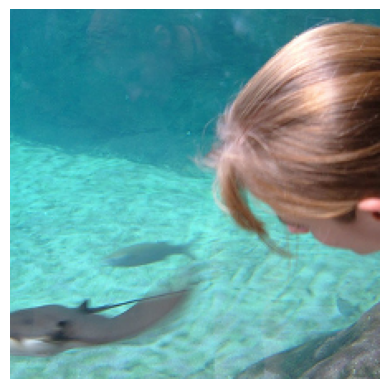

In [8]:
i = 0
label = y_train.argmax(axis=1)[i]
print(f"Label: {label} - {int_to_str[label]}")

x = BGR_to_RGB(X_train + mean_channels).astype(int)[i]
plt.imshow(x)
plt.axis('off')
plt.show()

ImageNet 데이터셋에 대해 사전학습된 ResNet50 모델을 불어온 뒤 시험데이터에 대해 예측한다.

In [ ]:
model = ResNet50(weights='imagenet')
preds = []
for x in X_test:
    x = x.reshape((1,) + x.shape)
    p = model(x).numpy().argmax(axis=1)
    preds.append(p)

시험데이터에 대한 정확도는 86%임을 확인한다.

In [11]:
acc = accuracy_score(y_test.argmax(axis=1), preds)
print("Test Accuracy: ", acc)

Test Accuracy:  0.86


`alibi.explainers.GradientSimilarity`를 객체화한다. 이 때, 유사도 척도는 $K_{\theta}^{(1)}$로 지정한다.

In [ ]:
gsm = GradientSimilarity(predictor=model,
                         loss_fn=categorical_crossentropy,
                         precompute_grads=False,
                         sim_fn='grad_cos')

학습데이터의 손실함수 미분값을 계산해야하므로 `.fit` step이 필요하다.

In [13]:
gsm.fit(X_train, y_train)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': False,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.9.6'}
)

시험데이터에 대해 무작위 샘플을 5개 뽑고 모델 예측 결과를 저장한다.

In [ ]:
idx_samples = np.array([np.random.choice(range(5 * i, 5 * i + 5)) for i in range(10)])
idx_samples = np.random.choice(idx_samples, 5, replace=False)
X_sample, y_sample = X_test[idx_samples], y_test[idx_samples]
preds = model(X_sample).numpy().argmax(axis=1)

샘플링된 5개의 이미지에 대해 GS를 도출한다.

In [ ]:
expls = gsm.explain(X_sample, y_sample)

앞서 설명된 `expls.data`의 key를 확인한다.

In [16]:
print(expls.meta.keys())
print(expls.data.keys())

dict_keys(['name', 'type', 'explanations', 'params', 'version'])
dict_keys(['scores', 'ordered_indices', 'most_similar', 'least_similar'])


`plot_similar`, `plot_distribution`함수의 입력에 맞게 원본이미지, 실제 label값, 모델 예측값, 유사한 이미지 5개, 유사한 이미지들의 예측값을 dictionary로 구성하여 샘플링된 시험데이터에 대응되게 list화한다.

In [17]:
ds = []
for j in range(len(X_sample)):
    idx = expls.data['ordered_indices'][j]
    y_sim = y_train[idx].argmax(axis=1)
    X_sim = X_train[idx[:5]]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': (X_sample + mean_channels).astype(int)[j],
         'y': y_sample[j].argmax(),
         'pred': preds[j],
         'y_sim': y_sim,
         'preds_sim': preds_sim}
    ds.append(d)

원본 이미지(가장 왼쪽 열)에 대해 유사한 이미지 5개를 출력한다.

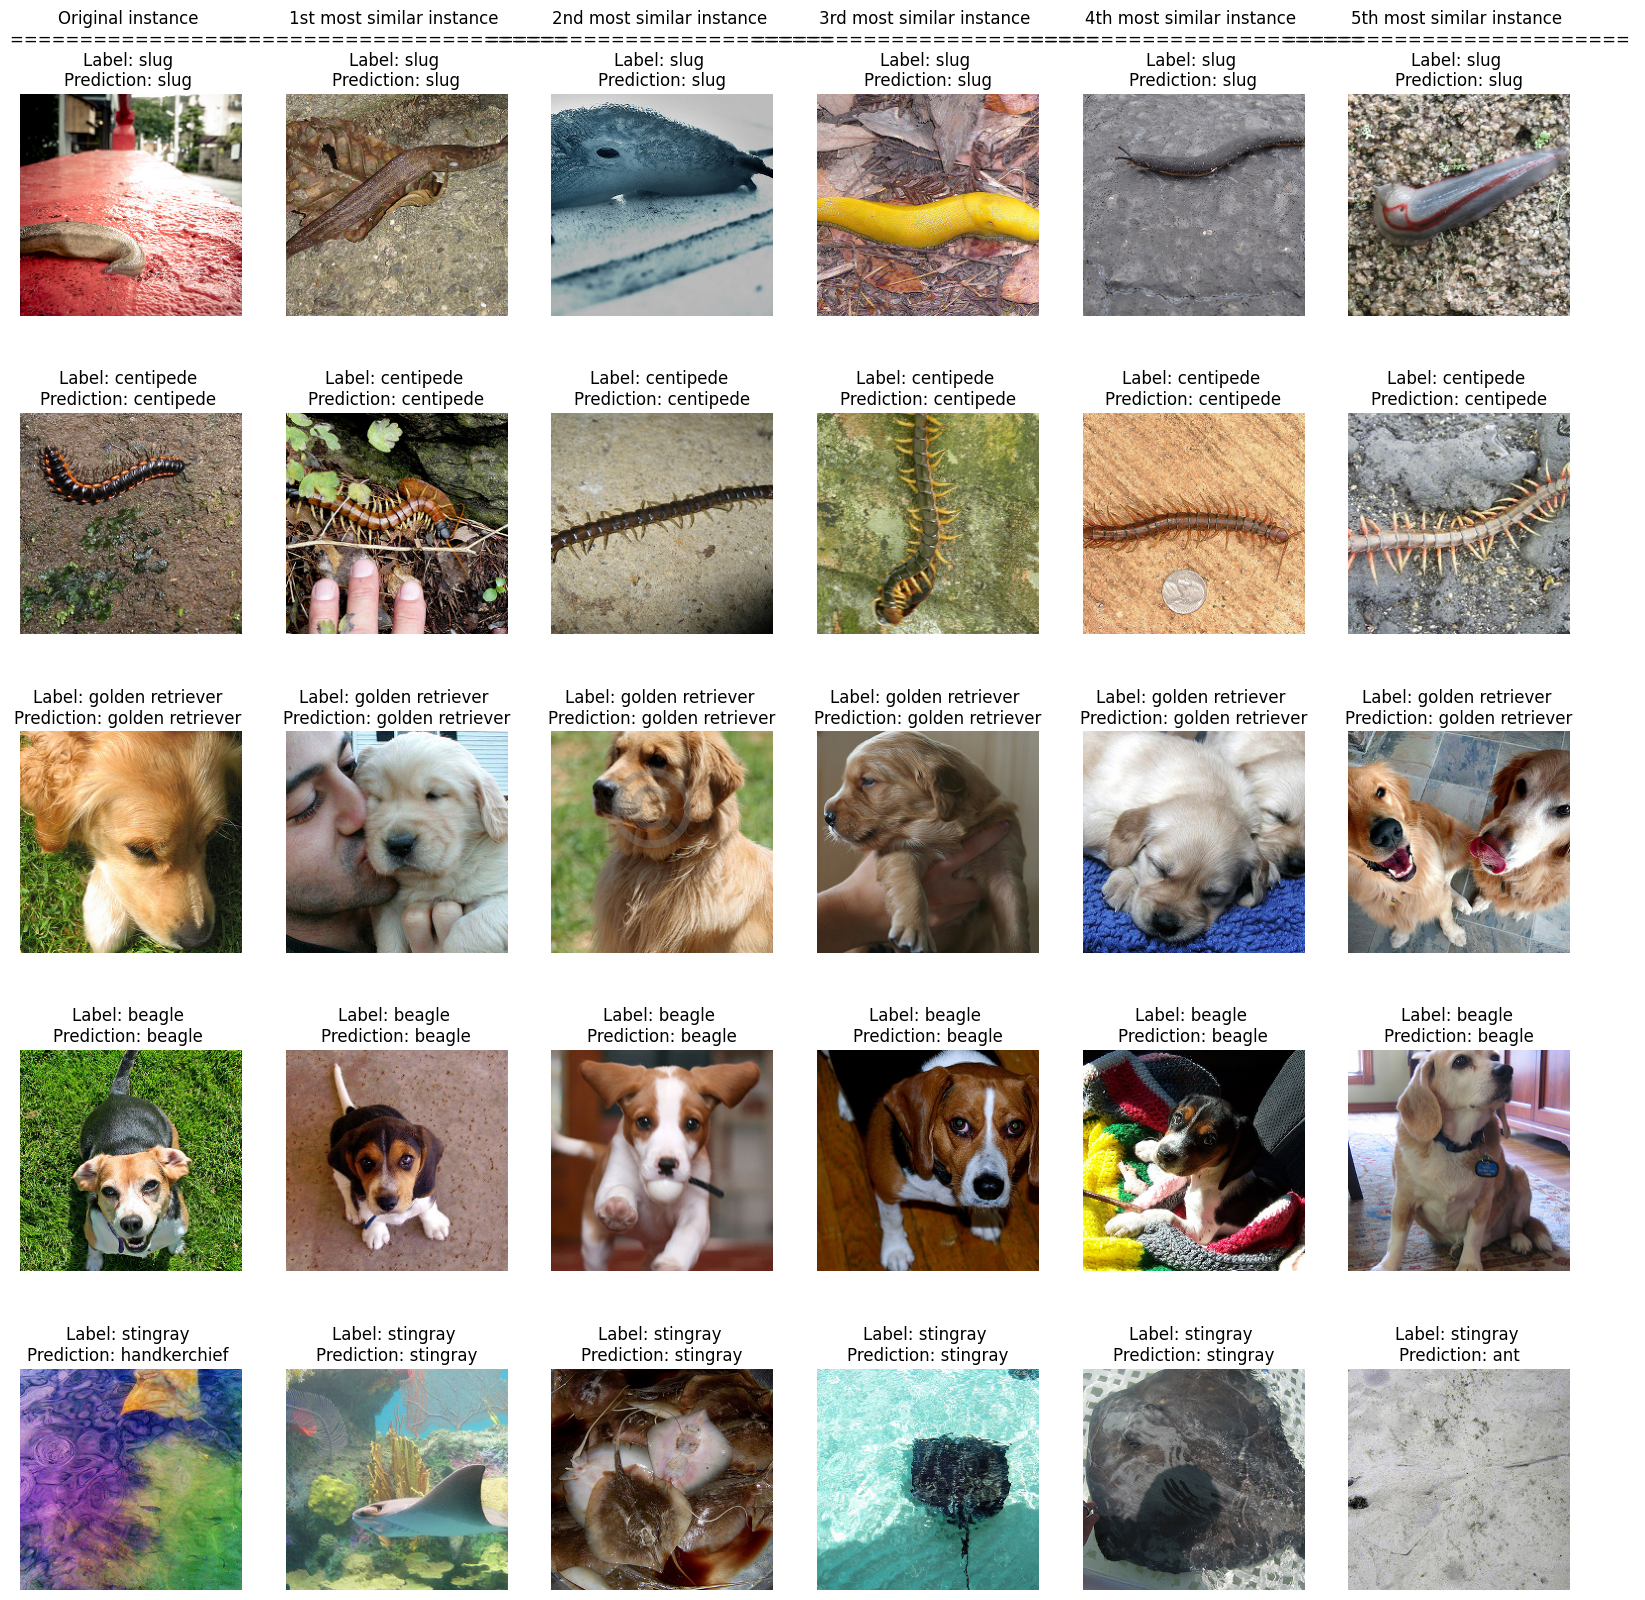

In [18]:
plot_similar(ds, expls, int_to_str, mean_channels)

샘플링된 시험데이터에 대하여 모든 학습데이터의 label별 GS score 평균을 출력한다.

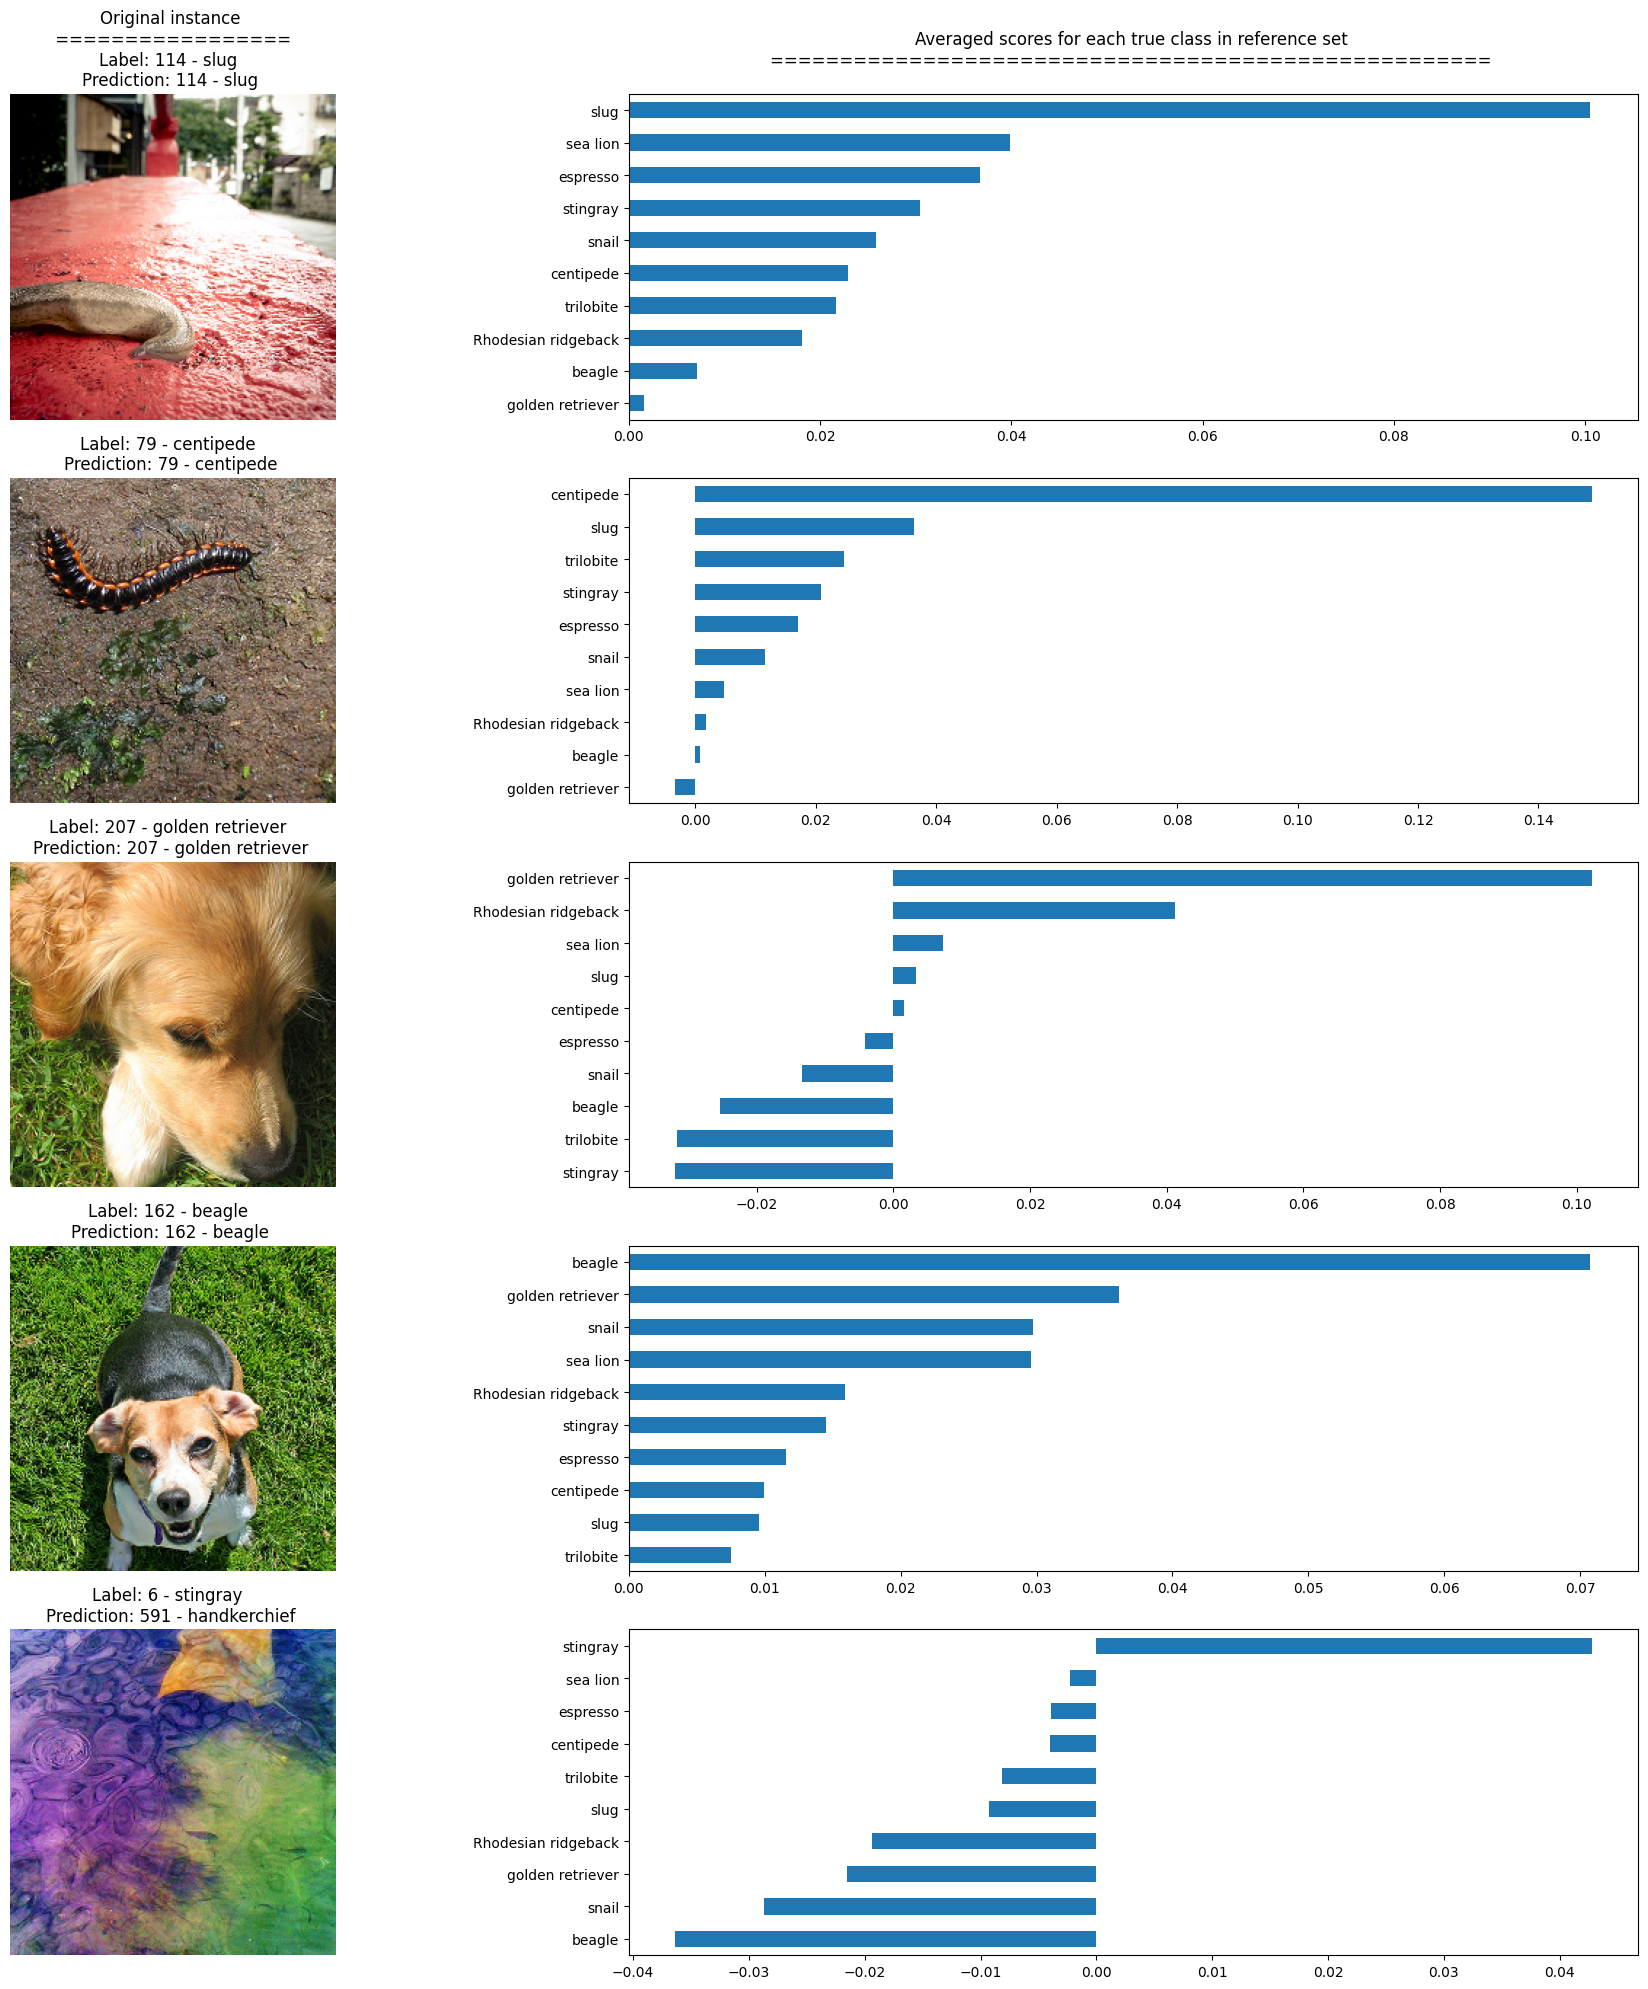

In [19]:
plot_distributions(ds, expls, int_to_str)